# Cross Country Performance Analysis

This notebook provides a comprehensive analysis of cross country running performance data from the National Running Club Database (NRCD).

## Overview
The analysis includes:
- Gender distribution and participation trends
- Performance analysis over time
- Geographic distribution of meets
- Performance normalization and adjustment for course conditions
- Statistical analysis of performance factors

## Data Sources
The data is sourced from the National Running Club Database (NRCD) located in `..data/nrcd/data`. The database includes:
- Team information
- Athlete demographics
- Meet details and results
- Course conditions and specifications

## Usage Instructions
1. Ensure all required Python packages are installed (see imports below)
2. Run cells sequentially to perform the analysis
3. The notebook includes functions for:
   - Data loading and preprocessing
   - Time normalization and adjustment
   - Performance analysis and visualization
4. Results can be exported for further analysis or reporting

## Note
This notebook is designed to work with the NRCD data structure. Do not modify the source data files directly as they are managed through the NRCD repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as sch
import plotly.express as px
import plotly.graph_objects as go
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

## Data Loading and Preprocessing

In [2]:
def load_data():
    """Load all CSV files from the data directory with error handling."""
    directory_path = '../data/nrcd/data'
    required_files = [
        'team.csv', 'athlete.csv', 'sport.csv', 'running_event.csv',
        'meet.csv', 'result.csv', 'course_details.csv', 'athlete_team_association.csv'
    ]
    
    # Check if directory exists
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"Data directory not found: {directory_path}")
    
    # Check if all required files exist
    missing_files = [f for f in required_files if not os.path.exists(os.path.join(directory_path, f))]
    if missing_files:
        raise FileNotFoundError(f"Missing required files: {', '.join(missing_files)}")
    
    try:
        # Load each CSV file into a pandas DataFrame
        team_df = pd.read_csv(os.path.join(directory_path, 'team.csv'))
        athlete_df = pd.read_csv(os.path.join(directory_path, 'athlete.csv'))
        sport_df = pd.read_csv(os.path.join(directory_path, 'sport.csv'))
        running_event_df = pd.read_csv(os.path.join(directory_path, 'running_event.csv'))
        meet_df = pd.read_csv(os.path.join(directory_path, 'meet.csv'))
        result_df = pd.read_csv(os.path.join(directory_path, 'result.csv'))
        course_details_df = pd.read_csv(os.path.join(directory_path, 'course_details.csv'))
        athlete_team_association_df = pd.read_csv(os.path.join(directory_path, 'athlete_team_association.csv'))
        
        # Convert date columns to datetime with error handling
        meet_df['start_date'] = pd.to_datetime(meet_df['start_date'], format='%Y-%m-%d', errors='coerce')
        meet_df['end_date'] = pd.to_datetime(meet_df['end_date'], format='%Y-%m-%d', errors='coerce')
        
        # Validate data
        if meet_df['start_date'].isna().any():
            print("Warning: Some start dates could not be parsed")
        if meet_df['end_date'].isna().any():
            print("Warning: Some end dates could not be parsed")
        
        return (team_df, athlete_df, sport_df, running_event_df, meet_df, 
                result_df, course_details_df, athlete_team_association_df)
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

# Load the data
try:
    team_df, athlete_df, sport_df, running_event_df, meet_df, result_df, course_details_df, athlete_team_association_df = load_data()
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error: {str(e)}")
    raise

Data loaded successfully!


## Data Merging and Initial Analysis

In [3]:
def merge_dataframes(athlete_df, result_df, meet_df):
    """Merge the dataframes for analysis."""
    # Merge athlete and result data
    athlete_result_df = pd.merge(athlete_df, result_df, on='athlete_id')
    
    # Merge the result with meet data
    full_df = pd.merge(athlete_result_df, meet_df, on='meet_id')
    
    return full_df

# Merge dataframes
full_df = merge_dataframes(athlete_df, result_df, meet_df)

# Analyze gender distribution
gender_counts = athlete_df['gender'].value_counts()
print(f"Number of men: {gender_counts.get('M', 0)}")
print(f"Number of women: {gender_counts.get('F', 0)}")

Number of men: 16127
Number of women: 10209


## Cross Country Performance Analysis

In [4]:
def analyze_cross_country_performance(sport_df, meet_df, result_df, athlete_df, running_event_df):
    """Analyze cross country performance data."""
    # Get cross country sport ID
    cross_country_sport_id = sport_df[sport_df['sport_name'].str.contains('Cross Country', case=False, na=False)]['sport_id'].values[0]
    
    # Define date range
    start_date = datetime(2024, 8, 1)
    end_date = datetime(2025, 5, 1)
    
    # Filter meets by date range and sport
    cross_country_meets = meet_df[
        (meet_df['sport_id'] == cross_country_sport_id) &
        (meet_df['start_date'] >= start_date) &
        (meet_df['start_date'] <= end_date)
    ]
    
    # Filter results for cross country meets
    cross_country_results = result_df[result_df['meet_id'].isin(cross_country_meets['meet_id'])]
    
    # Merge with athlete data
    cross_country_athletes = pd.merge(cross_country_results, athlete_df, on='athlete_id')
    
    # Merge with running event data to get event names
    cross_country_athletes = pd.merge(cross_country_athletes, running_event_df[['running_event_id', 'event_name']], 
                                    on='running_event_id', how='left')
    
    # Merge with meet data to get start_date
    cross_country_athletes = pd.merge(cross_country_athletes, cross_country_meets[['meet_id', 'start_date']], 
                                    on='meet_id', how='left')
    
    return cross_country_athletes

# Analyze cross country performance
cross_country_athletes = analyze_cross_country_performance(sport_df, meet_df, result_df, athlete_df, running_event_df)

## Time Processing and Normalization

In [5]:
def parse_time(time_str):
    """Convert time string to seconds."""
    parts = time_str.split(":")
    if len(parts) == 3:
        hours, minutes, seconds = map(float, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(float, parts)
        return minutes * 60 + seconds
    else:
        return float(time_str)

def format_parsed_time(seconds):
    """Convert seconds to formatted time string."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    if hours > 0:
        return f"{hours}:{minutes:02d}:{seconds:05.2f}"
    elif minutes > 0:
        return f"{minutes}:{seconds:05.2f}"
    else:
        return f"{seconds:05.2f}"

def adjust_time_for_race(event_name, time, course_details, gender):
    """Adjust race time based on course details and conditions."""
    event_dist = None
    if event_name.endswith('m'):
        event_dist = float(event_name.replace('m', '').strip())
    elif event_name.endswith('mi'):
        event_dist = float(event_name.replace('mi', '').strip()) * 1609.34
    
    hill_slow_time = 0
    hill_speed_time = 0
    
    if event_dist:
        if pd.notna(course_details.get('elevation_gain')) or pd.notna(course_details.get('elevation_loss')):
            if pd.notna(course_details.get('elevation_gain')):
                grade_increase_percentage = course_details['elevation_gain'] / event_dist * 100
                hill_slow_time = time * 0.04 * grade_increase_percentage
            if pd.notna(course_details.get('elevation_loss')):
                grade_decrease_percentage = course_details['elevation_loss'] / event_dist * 100
                hill_speed_time = time * 0.0267 * grade_decrease_percentage
            time += hill_speed_time - hill_slow_time

        if pd.notna(course_details.get('estimated_course_distance')):
            factor = event_dist / course_details['estimated_course_distance']
            if gender == 'F':
                time *= factor ** 1.055
            elif gender == 'M':
                time *= factor ** 1.08

    if pd.notna(course_details.get('temperature')) and pd.notna(course_details.get('dew_point')):
        weather_factor = course_details['temperature'] + course_details['dew_point']
        if weather_factor > 100:
            percent_increase = 0.0015 * (weather_factor - 100) ** 2
            time *= 1 - (percent_increase / 100)

    return time

def normalize_and_adjust_time(row):
    """Normalize and adjust time for a given row of data."""
    parsed_time = parse_time(row['result_time'])
    
    if pd.notna(row.get('course_details_id')):
        course_details = {
            'elevation_gain': row.get('elevation_gain'),
            'elevation_loss': row.get('elevation_loss'),
            'estimated_course_distance': row.get('estimated_course_distance'),
            'temperature': row.get('temperature'),
            'dew_point': row.get('dew_point')
        }
        adjusted_time = adjust_time_for_race(row['event_name'], parsed_time, course_details, row['gender'])
    else:
        adjusted_time = parsed_time

    event_dist = None
    if row['event_name'].endswith('m'):
        event_dist = float(row['event_name'].replace('m', '').strip())
    elif row['event_name'].endswith('mi'):
        event_dist = float(row['event_name'].replace('mi', '').strip()) * 1609.34

    if event_dist:
        if row['gender'] == 'F':
            normalized_time = adjusted_time * (6000 / event_dist)**1.08
        elif row['gender'] == 'M':
            normalized_time = adjusted_time * (8000 / event_dist)**1.055
        else:
            normalized_time = adjusted_time
    else:
        normalized_time = adjusted_time
        
    return format_parsed_time(normalized_time)

# Process and normalize times
cross_country_athletes['final_adjusted_time'] = cross_country_athletes.apply(normalize_and_adjust_time, axis=1)
cross_country_athletes['final_parsed_adjusted_time'] = cross_country_athletes['final_adjusted_time'].apply(parse_time)

## Performance Visualization

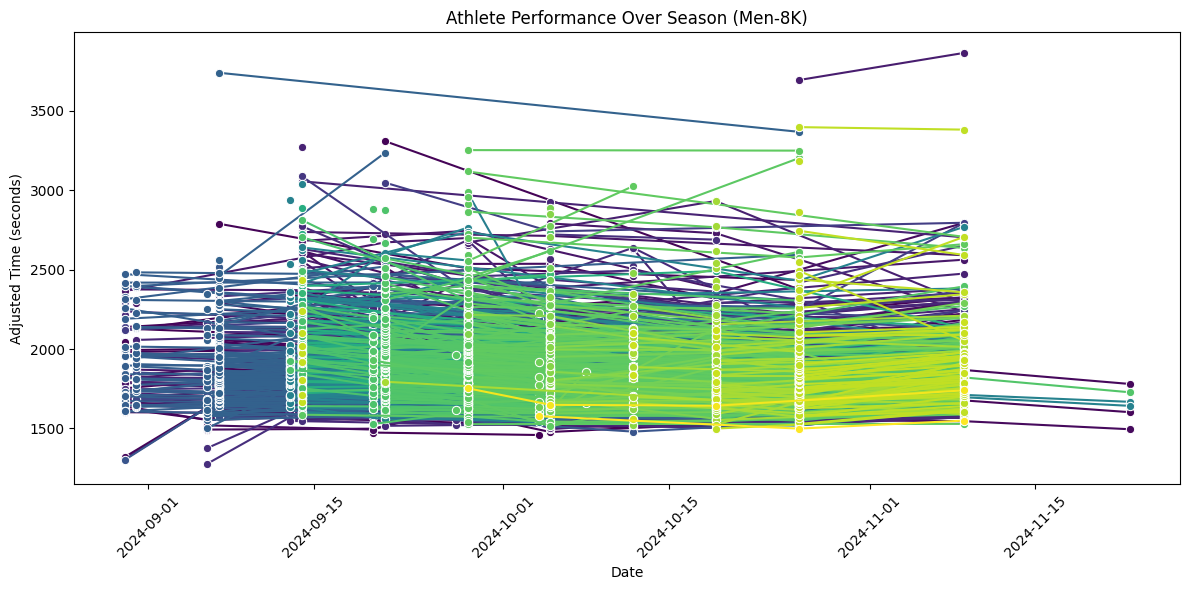

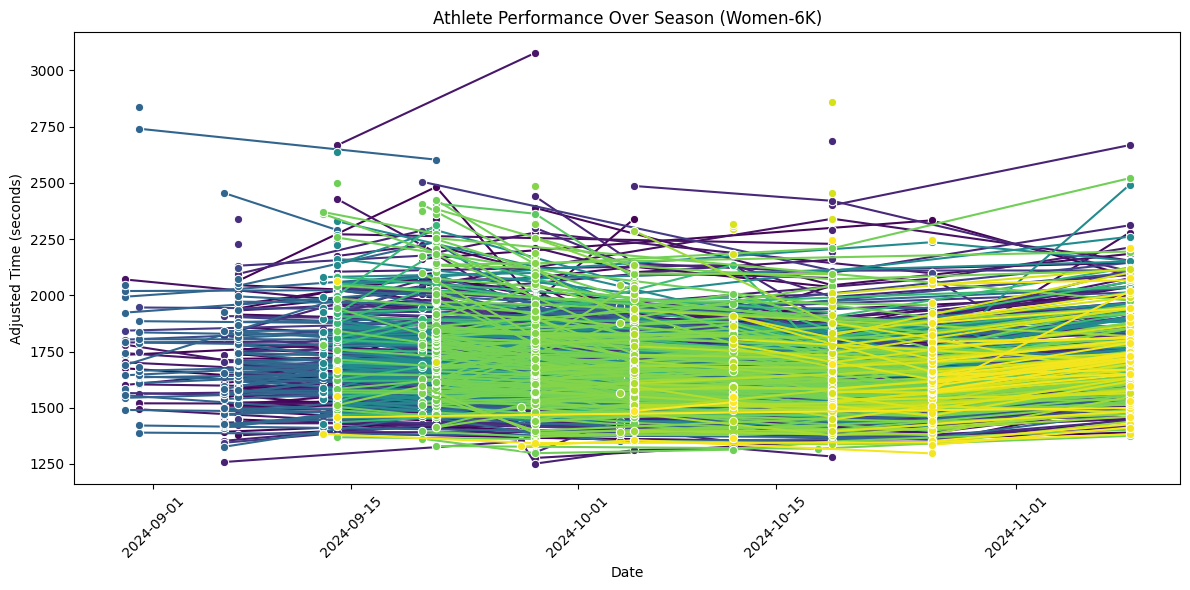

In [6]:
def plot_performance_over_time(data, gender):
    """Plot performance over time for a specific gender."""
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='start_date', y='final_parsed_adjusted_time', 
                hue='athlete_id', marker='o', palette='viridis', legend=None)
    plt.title(f'Athlete Performance Over Season ({gender}-{"8K" if gender == "Men" else "6K"})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Separate male and female athletes
male_athletes = cross_country_athletes[cross_country_athletes['gender'] == 'M']
female_athletes = cross_country_athletes[cross_country_athletes['gender'] == 'F']

# Plot performance over time
plot_performance_over_time(male_athletes, 'Men')
plot_performance_over_time(female_athletes, 'Women')

## Improvement Rate Analysis

In [7]:
def calculate_improvement_rate(data):
    """Calculate improvement rate using linear regression."""
    slopes = []
    for athlete_id in data['athlete_id'].unique():
        athlete_df = data[data['athlete_id'] == athlete_id].sort_values('start_date')
        if len(athlete_df) > 1:
            X = np.array(athlete_df['start_date'].map(pd.Timestamp.toordinal)).reshape(-1, 1)
            y = athlete_df['final_parsed_adjusted_time'].values
            
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            slopes.append(slope)
    
    return np.mean(slopes)

# Calculate improvement rates
male_improvement = calculate_improvement_rate(male_athletes)
female_improvement = calculate_improvement_rate(female_athletes)

print(f"Average Improvement Rate (Men): {male_improvement:.2f} seconds per day")
print(f"Average Improvement Rate (Women): {female_improvement:.2f} seconds per day")

Average Improvement Rate (Men): -0.58 seconds per day
Average Improvement Rate (Women): -0.12 seconds per day


## State Name Normalization for Geographic Analysis

In [8]:
# Map full state names and abbreviations to abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}
# Create a new dictionary with reverse mappings and common misspellings
state_abbreviations_with_reverse = state_abbreviations.copy()
for abbr in state_abbreviations.values():
    state_abbreviations_with_reverse[abbr] = abbr
# Add common misspellings
state_abbreviations_with_reverse.update({
    'Pennslyvania': 'PA',
    'Pennsylania': 'PA',
    'Masssachusetts': 'MA',
    'Wiaconsin': 'WI',
    'Viriginia': 'VA',
    'Flordia': 'FL',
    'D.C.': 'DC',
    'DC': 'DC'
})

def normalize_state(state):
    """Normalize state names to their two-letter abbreviations."""
    state = str(state).strip()
    # Handle special cases
    if state.lower() in ['hill', 'university of florida']:
        return None
    # Try direct lookup first
    if state in state_abbreviations_with_reverse:
        return state_abbreviations_with_reverse[state]
    # Try case-insensitive lookup
    state_lower = state.lower()
    for key in state_abbreviations_with_reverse:
        if key.lower() == state_lower:
            return state_abbreviations_with_reverse[key]
    # If no match found, return None
    return None

# Apply normalization and filter out None values
meet_df['normalized_state'] = meet_df['meet_state'].apply(normalize_state)
meet_df = meet_df.dropna(subset=['normalized_state'])


## Geographic Distribution Analysis

In [9]:
def create_state_choropleth(meet_df):
    """Create a choropleth map of meets by state."""
    results_by_state = meet_df['normalized_state'].value_counts().to_dict()
    state_data = pd.DataFrame(list(results_by_state.items()),
                            columns=['State', 'Results'])
    state_data['text'] = state_data['Results'].astype(str)
    fig = go.Figure(data=go.Choropleth(
        locations=state_data['State'],
        z=state_data['Results'],
        locationmode='USA-states',
        colorscale='Viridis',
        colorbar_title="Number of Meets",
        text=state_data['text'],
        hovertemplate='<b>%{location}</b><br>Meets: %{z}<extra></extra>'
    ))
    fig.update_layout(
        title_text='Number of NRCD Meets by State',
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
        ),
    )
    fig.show()

# Create state choropleth
create_state_choropleth(meet_df)

## Gender Distribution Analysis by Year


2024 Cross Country: Gender vs # of Races
Number of men: 4965
Number of women: 2872

Distribution of number of Cross Country meets for men:
count    2185.000000
mean        2.271854
std         1.368557
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: meet_id, dtype: float64

Distribution of number of Cross Country meets for women:
count    1281.000000
mean        2.241998
std         1.347156
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: meet_id, dtype: float64

T-statistic: 0.623513793571414
P-value: 0.532987992973528


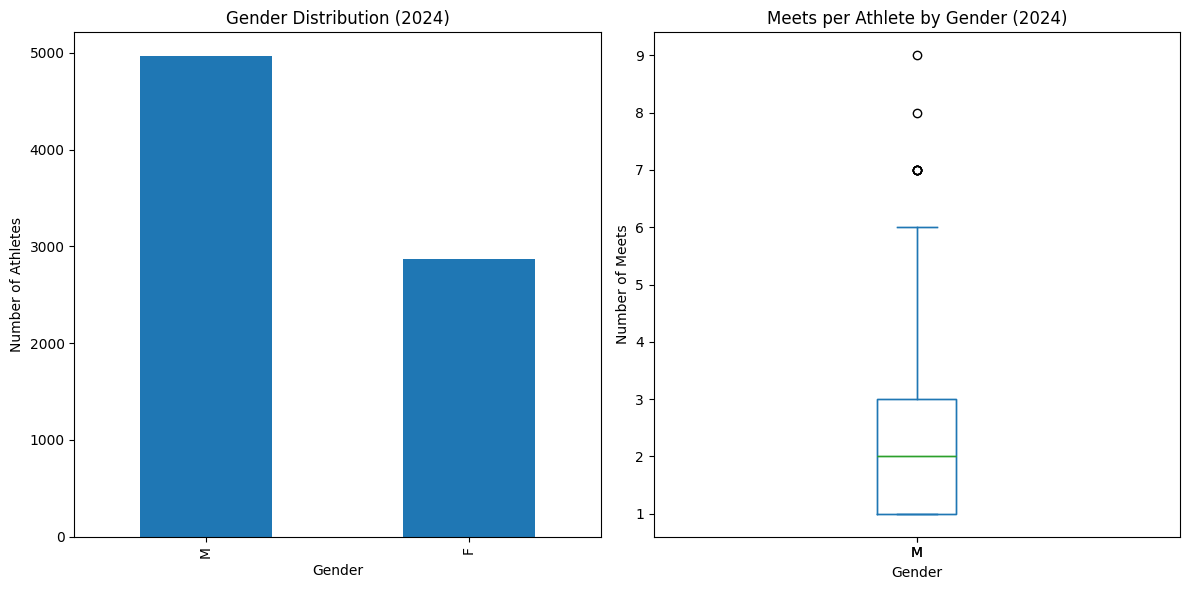


2023 Cross Country: Gender vs # of Races
Number of men: 4803
Number of women: 2757

Distribution of number of Cross Country meets for men:
count    2134.000000
mean        2.243674
std         1.306210
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: meet_id, dtype: float64

Distribution of number of Cross Country meets for women:
count    1304.000000
mean        2.108129
std         1.265200
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: meet_id, dtype: float64

T-statistic: 2.9874717691085184
P-value: 0.0028328426933623397


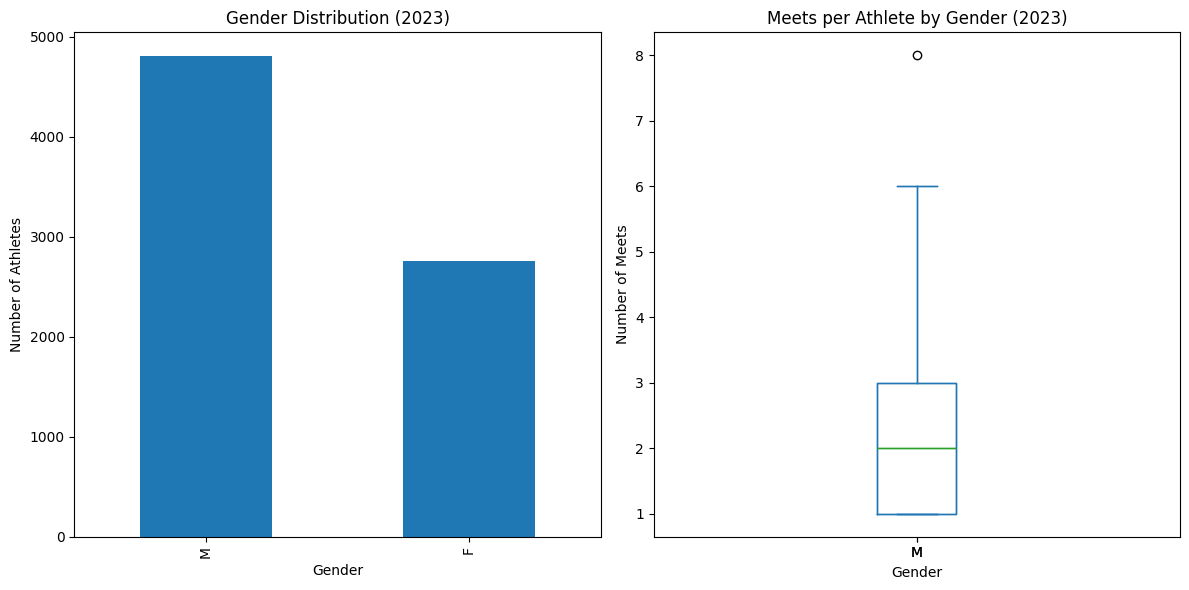

In [10]:
def analyze_gender_distribution_by_year(sport_df, meet_df, result_df, athlete_df, year):
    """Analyze gender distribution for a specific year."""
    # Get cross country sport ID
    cross_country_sport_id = sport_df[sport_df['sport_name'].str.contains('Cross Country', case=False, na=False)]['sport_id'].values[0]
    
    # Define date range for the year
    start_date = datetime(year, 8, 1)
    end_date = datetime(year + 1, 5, 1)
    
    # Filter meets by date range and sport
    cross_country_meets = meet_df[
        (meet_df['sport_id'] == cross_country_sport_id) &
        (meet_df['start_date'] >= start_date) &
        (meet_df['start_date'] <= end_date)
    ]
    
    # Filter results for cross country meets
    cross_country_results = result_df[result_df['meet_id'].isin(cross_country_meets['meet_id'])]
    
    # Merge with athlete data
    cross_country_athletes = pd.merge(cross_country_results, athlete_df, on='athlete_id')
    
    # Count unique athletes by gender
    gender_counts = cross_country_athletes['gender'].value_counts()
    
    # Calculate meets per athlete by gender
    meets_per_athlete = cross_country_athletes.groupby(['athlete_id', 'gender'])['meet_id'].nunique()
    meets_by_gender = meets_per_athlete.groupby('gender')
    
    # Perform t-test
    male_meets = meets_per_athlete[meets_per_athlete.index.get_level_values('gender') == 'M']
    female_meets = meets_per_athlete[meets_per_athlete.index.get_level_values('gender') == 'F']
    t_stat, p_value = stats.ttest_ind(male_meets, female_meets)
    
    return gender_counts, meets_by_gender, t_stat, p_value

# Analyze gender distribution for 2024 and 2023
for year in [2024, 2023]:
    print(f"\n{year} Cross Country: Gender vs # of Races")
    gender_counts, meets_by_gender, t_stat, p_value = analyze_gender_distribution_by_year(sport_df, meet_df, result_df, athlete_df, year)
    
    print(f"Number of men: {gender_counts.get('M', 0)}")
    print(f"Number of women: {gender_counts.get('F', 0)}")
    
    print("\nDistribution of number of Cross Country meets for men:")
    print(meets_by_gender.get_group('M').describe())
    
    print("\nDistribution of number of Cross Country meets for women:")
    print(meets_by_gender.get_group('F').describe())
    
    print(f"\nT-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot gender distribution
    plt.subplot(1, 2, 1)
    gender_counts.plot(kind='bar')
    plt.title(f'Gender Distribution ({year})')
    plt.xlabel('Gender')
    plt.ylabel('Number of Athletes')
    
    # Plot meets per athlete distribution
    plt.subplot(1, 2, 2)
    meets_by_gender.plot(kind='box')
    plt.title(f'Meets per Athlete by Gender ({year})')
    plt.xlabel('Gender')
    plt.ylabel('Number of Meets')
    
    plt.tight_layout()
    plt.show()